In [1]:
#Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [2]:
class PortfolioOptimizer:
    ANNUAL_FACTOR = 252
    RF_RATE = 0.0368  # TAIBOR
    SQRT_252 = 15.8745  # Precomputed sqrt(252)

    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.returns = None
        self.benchmark_returns = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_start = '2021-08-12'
        self.train_end = '2023-12-29'
        self.val_start = '2024-01-02'
        self.val_end = '2024-06-28'
        self.test_start = '2024-07-02'

    def to_tensor(self, data):
        """Convert data to PyTorch tensor efficiently"""
        try:
            if isinstance(data, (pd.DataFrame, pd.Series)):
                data = data.values
            return torch.tensor(data, dtype=torch.float32, device=self.device)
        except Exception as e:
            print(f"Error converting to tensor: {e}")
            return data

    def objective_function(self, weights, returns, target_returns=None, tracking_weight=0.5):
        """Objective function: L(w) = α * sqrt(E[(Rp - Rb)²]) - (1-α) * E[Rp - Rb]"""
        portfolio_returns = torch.sum(returns * weights, dim=1)
        excess_returns = portfolio_returns - target_returns if target_returns is not None else portfolio_returns
        tracking_error = torch.sqrt(torch.mean(excess_returns ** 2)) * self.SQRT_252
        mean_excess_return = torch.mean(excess_returns)
        return tracking_weight * tracking_error - (1 - tracking_weight) * mean_excess_return

    def load_data(self):
        """Load and prepare data"""
        try:
            self.df = pd.read_excel(self.file_path, index_col='Date', parse_dates=True)
            corr_matrix = self.df.corr()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
            self.df = self.df.drop(columns=to_drop)
            self.benchmark_returns = self.df['2800.HK']
            self.returns = self.df.drop('2800.HK', axis=1)
            print(f"Data loaded successfully. Shape: {self.df.shape}")
            return True
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False

    class PortfolioNet(nn.Module):
        def __init__(self, n_assets, min_weight, max_weight, max_stocks, device):
            super().__init__()
            self.device = device
            self.weights = nn.Parameter(torch.ones(n_assets, device=device) / n_assets)
            self.selection = nn.Parameter(torch.ones(n_assets, device=device))
            self.min_weight = min_weight
            self.max_weight = max_weight
            self.max_stocks = max_stocks

        def forward(self):
            selection_prob = torch.sigmoid(self.selection)
            _, top_indices = torch.topk(selection_prob, k=self.max_stocks)
            selection_mask = torch.zeros_like(selection_prob, device=self.device)
            selection_mask[top_indices] = 1.0
            
            weights = torch.sigmoid(self.weights) * selection_mask
            weights = torch.where(weights < self.min_weight, torch.zeros_like(weights), weights)
            
            total_weight = weights.sum()
            if total_weight > 0:
                weights = weights / total_weight
            
            weights = torch.clamp(weights, 0, self.max_weight)
            if weights.sum() > 0:
                weights = weights / weights.sum()
            
            return weights

    def optimize_portfolio(self, tracking_weight=0.7, max_weight=0.20, min_weight=0.02, contamination=0.01, window_size=10, max_stocks=15):
        """Optimize portfolio weights with cardinality constraint"""
        print("\nOptimizing portfolio weights with rolling window...")
        print(f"Maximum number of stocks allowed: {max_stocks}")

        n_assets = len(self.returns.columns)
        returns_tensor = self.to_tensor(self.returns)
        benchmark_tensor = self.to_tensor(self.benchmark_returns)

        # Anomaly detection
        features = pd.DataFrame({
            'returns': self.benchmark_returns,
            'rolling_std': self.benchmark_returns.rolling(window=60).std(),
            'rolling_mean': self.benchmark_returns.rolling(window=60).mean()
        }).dropna()
        
        iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=50, n_jobs=-1)
        predictions = iso_forest.fit_predict(features)
        rebalancing_dates = features.index[predictions == -1]

        optimal_weights_dict = {}
        model = self.PortfolioNet(n_assets, min_weight, max_weight, max_stocks, self.device).to(self.device)
        optimizer = optim.LBFGS(model.parameters(), lr=0.05)

        window_indices = [(max(0, self.returns.index.get_loc(rebal_date) - window_size), 
                          self.returns.index.get_loc(rebal_date), rebal_date) 
                         for rebal_date in rebalancing_dates]

        for start_idx, end_idx, rebal_date in tqdm(window_indices, desc="Optimizing portfolios"):
            window_returns = returns_tensor[start_idx:end_idx]
            window_benchmark = benchmark_tensor[start_idx:end_idx]

            def closure():
                optimizer.zero_grad()
                weights = model()
                loss = self.objective_function(weights, window_returns, window_benchmark, tracking_weight)
                loss.backward()
                return loss

            optimizer.step(closure)
            with torch.no_grad():
                optimal_weights = model().cpu().numpy()
                optimal_weights_dict[rebal_date] = optimal_weights

            if torch.cuda.is_available() and torch.cuda.memory_allocated() > 0.9 * torch.cuda.max_memory_allocated():
                torch.cuda.empty_cache()

        self.rebalancing_dates = rebalancing_dates
        self.optimal_weights_dict = optimal_weights_dict

        if optimal_weights_dict:
            final_weights = optimal_weights_dict[max(optimal_weights_dict.keys())]
            active_positions = (final_weights > min_weight).sum()
            print(f"\nOptimization completed successfully!")
            print(f"Number of rebalancing points: {len(optimal_weights_dict)}")
            print(f"Number of active positions in final portfolio: {active_positions}")
            return final_weights
        
        return np.ones(n_assets) / n_assets

    def prepare_var_data(self, data, lag):
        """Prepare VAR data using tensor unfolding"""
        unfolded = data.unfold(0, lag + 1, 1)
        X = unfolded[:, :, :-1].reshape(unfolded.shape[0], -1)
        y = unfolded[:, :, -1]
        return X, y

    def train_var(self, weights=None, lag=2, alpha=1.0):
        """VAR model training using PyTorch with ridge penalty"""
        try:
            train_data = self.to_tensor(self.returns[self.train_start:self.val_start])
            X_train, y_train = self.prepare_var_data(train_data, lag)

            class VARModel(nn.Module):
                def __init__(self, input_dim, lag):
                    super().__init__()
                    self.linear = nn.Linear(input_dim * lag, input_dim)
                    self.dropout = nn.Dropout(0.2)

                def forward(self, x):
                    x = self.dropout(x)
                    return self.linear(x)

                def ridge_penalty(self):
                    return sum(torch.norm(param, 2) for param in self.parameters())

            model = VARModel(train_data.shape[1], lag).to(self.device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()

            train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

            print("\nTraining VAR model with ridge penalty...")
            for epoch in range(100):
                model.train()
                total_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    optimizer.zero_grad()
                    pred = model(batch_X)
                    mse_loss = criterion(pred, batch_y)
                    ridge_loss = alpha * model.ridge_penalty()
                    loss = mse_loss + ridge_loss
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                if (epoch + 1) % 10 == 0:
                    avg_loss = total_loss / len(train_loader)
                    print(f"Epoch {epoch+1}/100, Loss: {avg_loss:.6f}")

            return True
        except Exception as e:
            print(f"Error in VAR model training: {str(e)}")
            return False

    def find_optimal_lag(self, max_lag=10):
        """Find optimal lag using BIC criterion"""
        try:
            train_data = self.to_tensor(self.returns[self.train_start:self.val_start])
            n_samples, n_features = train_data.shape
            best_bic = float('inf')
            optimal_lag = 5

            print("\nFinding optimal lag using BIC criterion...")
            for lag in range(1, max_lag + 1):
                X, y = self.prepare_var_data(train_data, lag)
                predictions = torch.mean(X.view(X.shape[0], n_features, lag), dim=2)
                residuals = y - predictions
                mse = torch.mean(residuals**2)
                n = len(residuals)
                k = lag * n_features + n_features
                log_likelihood = -0.5 * n * (torch.log(mse) + 1 + torch.log(torch.tensor(2 * np.pi)))
                bic = torch.log(torch.tensor(n)) * k - 2 * log_likelihood
                
                if bic < best_bic:
                    best_bic = bic
                    optimal_lag = lag
                print(f"Lag {lag}: BIC = {bic:.2f}")

            print(f"\nOptimal lag selected: {optimal_lag}")
            return optimal_lag
        except Exception as e:
            print(f"Error in finding optimal lag: {str(e)}")
            return 5

    def calculate_performance_metrics(self, returns, weights):
        """Calculate performance metrics using PyTorch"""
        returns_tensor = self.to_tensor(returns)
        weights_tensor = self.to_tensor(weights)
        portfolio_returns = torch.sum(returns_tensor * weights_tensor, dim=1)

        annual_return = portfolio_returns.mean() * self.ANNUAL_FACTOR
        annual_vol = portfolio_returns.std() * self.SQRT_252
        excess_return = annual_return - self.RF_RATE
        sharpe = excess_return / annual_vol if annual_vol != 0 else 0.0

        negative_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = torch.sqrt(torch.mean(negative_returns**2)) * self.SQRT_252 if len(negative_returns) > 0 else 1e-8
        sortino = excess_return / downside_std

        cum_returns = torch.cumprod(1 + portfolio_returns, dim=0)
        rolling_max = torch.cummax(cum_returns, dim=0)[0]
        drawdowns = (cum_returns - rolling_max) / rolling_max
        max_drawdown = torch.min(drawdowns)

        return {
            'annual_return': annual_return.item(),
            'annual_vol': annual_vol.item(),
            'sharpe': sharpe.item(),
            'sortino': sortino.item(),
            'max_drawdown': max_drawdown.item()
        }

    def plot_results(self, weights):
        """Plot portfolio allocation, cumulative returns, and performance metrics"""
        # Convert to numpy for plotting and calculations
        weights = weights.cpu().numpy() if torch.is_tensor(weights) else weights
        portfolio_returns = (self.returns * weights).sum(axis=1)
        cum_returns = (1 + portfolio_returns).cumprod()
        cum_benchmark = (1 + self.benchmark_returns).cumprod()

        # Plotting
        plt.ioff()  # Turn off interactive mode to ensure compatibility
        fig = plt.figure(figsize=(20, 10))

        # Pie chart - restored to original specs
        plt.subplot(1, 2, 1)
        mask = weights > 0.001
        filtered_weights = weights[mask]
        filtered_labels = [label for i, label in enumerate(self.returns.columns) if mask[i]]
        plt.pie(filtered_weights, labels=filtered_labels, autopct='%1.1f%%', startangle=90,
                textprops={'fontsize': 8}, labeldistance=1.1)
        plt.title('Portfolio Allocation', pad=20, fontsize=24)

        # Cumulative returns
        plt.subplot(1, 2, 2)
        plt.plot(cum_returns.index, (cum_returns - 1) * 100, label='Portfolio', linewidth=2)
        plt.plot(cum_benchmark.index, (cum_benchmark - 1) * 100, label='Benchmark (2800.HK)', linewidth=2)
        plt.axvline(pd.to_datetime(self.val_start), color='gray', linestyle='--', linewidth=1)
        plt.axvline(pd.to_datetime(self.test_start), color='gray', linestyle='--', linewidth=1)
        
        if hasattr(self, 'rebalancing_dates'):
            for date in self.rebalancing_dates:
                plt.axvline(date, color='r', linestyle=':', alpha=0.3)
            plt.plot([], [], color='r', linestyle=':', label='Rebalancing Points', alpha=0.3)

        plt.title('Cumulative Returns', pad=20, fontsize=24)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Cumulative Return (%)', fontsize=18)
        plt.legend(fontsize=12, loc='upper left')
        plt.grid(True)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.savefig('HSI_portfolio_analysis_forest_CUDA.png', dpi=300, bbox_inches='tight')
        plt.show()  # Restored to display the plot in Spyder
        plt.close()  # Close the figure after displaying

        # Performance analysis
        print("\nPerformance Analysis")
        print("=" * 50)

        periods = {
            'Full Period': (self.returns.index[0], self.returns.index[-1]),
            'Training': (pd.to_datetime(self.train_start), pd.to_datetime(self.val_start)),
            'Validation': (pd.to_datetime(self.val_start), pd.to_datetime(self.test_start)),
            'Testing': (pd.to_datetime(self.test_start), self.returns.index[-1])
        }

        rf_rate = self.RF_RATE

        for period_name, (start_date, end_date) in periods.items():
            mask = (self.returns.index >= start_date) & (self.returns.index <= end_date)
            period_returns = portfolio_returns[mask]
            period_benchmark = self.benchmark_returns[mask]

            # Annualized return and volatility
            ann_return = period_returns.mean() * self.ANNUAL_FACTOR
            ann_vol = period_returns.std() * self.SQRT_252
            benchmark_ann_return = period_benchmark.mean() * self.ANNUAL_FACTOR
            benchmark_ann_vol = period_benchmark.std() * self.SQRT_252

            # Sharpe Ratio
            sharpe = (ann_return - rf_rate) / ann_vol if ann_vol != 0 else 0
            benchmark_sharpe = (benchmark_ann_return - rf_rate) / benchmark_ann_vol if benchmark_ann_vol != 0 else 0

            # Sortino Ratio
            downside_returns = period_returns[period_returns < 0]
            benchmark_downside = period_benchmark[period_benchmark < 0]
            downside_vol = downside_returns.std() * self.SQRT_252 if len(downside_returns) > 0 else np.inf
            benchmark_downside_vol = benchmark_downside.std() * self.SQRT_252 if len(benchmark_downside) > 0 else np.inf
            sortino = (ann_return - rf_rate) / downside_vol if downside_vol != np.inf else 0
            benchmark_sortino = (benchmark_ann_return - rf_rate) / benchmark_downside_vol if benchmark_downside_vol != np.inf else 0

            # Maximum Drawdown
            cum_rets = (1 + period_returns).cumprod()
            cum_bench = (1 + period_benchmark).cumprod()
            rolling_max = cum_rets.expanding(min_periods=1).max()
            drawdowns = (cum_rets - rolling_max) / rolling_max
            max_drawdown = drawdowns.min()
            rolling_max_bench = cum_bench.expanding(min_periods=1).max()
            drawdowns_bench = (cum_bench - rolling_max_bench) / rolling_max_bench
            max_drawdown_bench = drawdowns_bench.min()

            # Beta and Tracking Error
            covar = np.cov(period_returns, period_benchmark)[0,1]
            benchmark_var = np.var(period_benchmark)
            beta = covar / benchmark_var if benchmark_var != 0 else 1
            tracking_error = np.std(period_returns - period_benchmark) * self.SQRT_252
            information_ratio = (ann_return - benchmark_ann_return) / tracking_error if tracking_error != 0 else 0

            print(f"\n{period_name} ({start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')})")
            print("-" * 50)
            print(f"                  {'Portfolio':>10}  {'Benchmark':>10}")
            print(f"Annual Return     {ann_return:>10.2%}  {benchmark_ann_return:>10.2%}")
            print(f"Annual Volatility {ann_vol:>10.2%}  {benchmark_ann_vol:>10.2%}")
            print(f"Sharpe Ratio      {sharpe:>10.2f}  {benchmark_sharpe:>10.2f}")
            print(f"Sortino Ratio     {sortino:>10.2f}  {benchmark_sortino:>10.2f}")
            print(f"Maximum Drawdown  {max_drawdown:>10.2%}  {max_drawdown_bench:>10.2%}")
            print(f"Beta              {beta:>10.2f}  {1.00:>10.2f}")
            print(f"Tracking Error    {tracking_error:>10.2%}  {0.00:>10.2%}")
            print(f"Information Ratio {information_ratio:>10.2f}  {'N/A':>10}")

        # Final weights table
        print("\nFinal Portfolio Weights")
        print("=" * 50)
        weights_df = pd.DataFrame({
            'Asset': self.returns.columns,
            'Weight': weights * 100
        }).sort_values('Weight', ascending=False)
        weights_df['Weight'] = weights_df['Weight'].map('{:.2f}%'.format)
        print(weights_df.to_string(index=False))

        return True

    def export_rebalancing_allocations(self, weights):
        """Export rebalancing allocations to DataFrame"""
        try:
            if hasattr(self, 'optimal_weights_dict'):
                allocations = pd.DataFrame(self.optimal_weights_dict).T
                allocations.columns = self.returns.columns
                allocations.index.name = 'Date'
                allocations.to_csv('HSI_portfolio_allocations_forest_CUDA.csv')
                print("\nAllocations exported to 'HSI_portfolio_allocations_forest_CUDA.csv'")
                return allocations
            print("\nNo rebalancing allocations available.")
            return None
        except Exception as e:
            print(f"Error exporting allocations: {str(e)}")
            return None

Data loaded successfully. Shape: (860, 84)

Optimizing portfolio weights with rolling window...
Maximum number of stocks allowed: 15


Optimizing portfolios: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 23.27it/s]



Optimization completed successfully!
Number of rebalancing points: 8
Number of active positions in final portfolio: 5


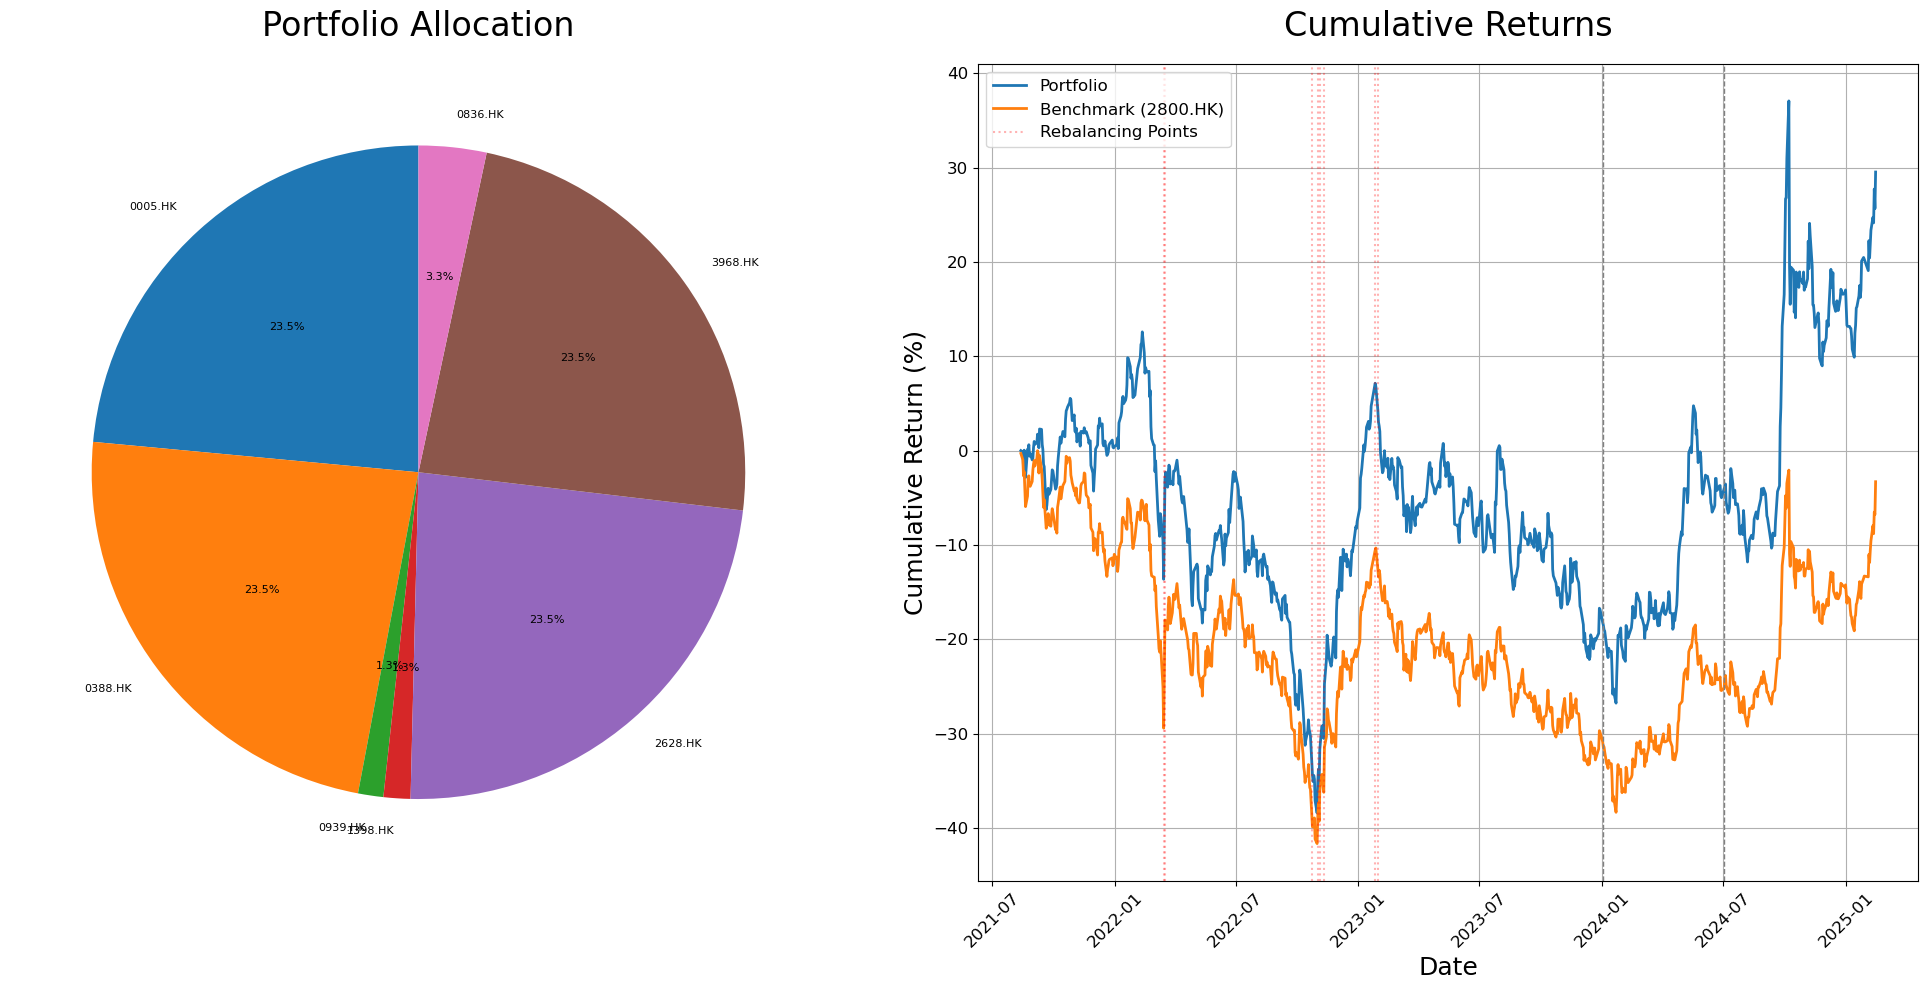


Performance Analysis

Full Period (2021-08-13 to 2025-02-14)
--------------------------------------------------
                   Portfolio   Benchmark
Annual Return         11.44%       2.36%
Annual Volatility     27.80%      25.90%
Sharpe Ratio            0.28       -0.05
Sortino Ratio           0.45       -0.09
Maximum Drawdown     -45.31%     -41.66%
Beta                    0.97        1.00
Tracking Error        12.11%       0.00%
Information Ratio       0.75         N/A

Training (2021-08-12 to 2024-01-02)
--------------------------------------------------
                   Portfolio   Benchmark
Annual Return         -5.10%     -12.44%
Annual Volatility     26.74%      26.32%
Sharpe Ratio           -0.33       -0.61
Sortino Ratio          -0.57       -1.08
Maximum Drawdown     -45.31%     -41.66%
Beta                    0.91        1.00
Tracking Error        12.38%       0.00%
Information Ratio       0.59         N/A

Validation (2024-01-02 to 2024-07-02)
----------------------

In [3]:
def main():
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    file_path = r'F:\HK Research 2\HSI_members_returns.xlsx'
    optimizer = PortfolioOptimizer(file_path)

    if not optimizer.load_data():
        return

    optimal_weights = optimizer.optimize_portfolio()
    if optimal_weights is not None:
        optimizer.plot_results(optimal_weights)
        allocations_df = optimizer.export_rebalancing_allocations(optimal_weights)
        if allocations_df is not None:
            print("\nSample of exported allocations:")
            print(allocations_df.head())

if __name__ == "__main__":
    main()